In [78]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, matthews_corrcoef, balanced_accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.inspection import DecisionBoundaryDisplay

In [79]:
# Load data
results = pd.read_csv('../Data/results1000.csv', delimiter=',') 
results_UC = pd.read_csv('../Data/unit_comitment1000.csv', delimiter=',')

# Check if units are always ON or OFF
targets = results_UC[["G1","G2","G3"]]
print(targets.mean())

# Filter out units that are always ON or OFF
units_to_classify = targets.columns[(targets.mean() > 0) & (targets.mean() < 1)]
print(f"Units to classify: {units_to_classify}")
print("-"*50)
targets = targets[units_to_classify]
features = results[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]

# Standardize features
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=results[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']].columns)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.3, random_state=42, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Shape
print("Shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

G1    1.000000
G2    0.696333
G3    0.965833
dtype: float64
Units to classify: Index(['G2', 'G3'], dtype='object')
--------------------------------------------------
Shapes:  (16800, 5) (3600, 5) (16800, 2) (3600, 2) (3600, 5) (3600, 2)


In [80]:
# Map G2 and G3 combinations to multi-class labels
def map_to_class(row):
    if row['G2'] == 1 and row['G3'] == 1:
        return 'A'
    elif row['G2'] == 1 and row['G3'] == 0:
        return 'B'
    elif row['G2'] == 0 and row['G3'] == 1:
        return 'C'
    else:
        return 'D'

# Apply this to your targets
y_train_multi = y_train.apply(map_to_class, axis=1)
y_test_multi = y_test.apply(map_to_class, axis=1)
y_val_multi = y_val.apply(map_to_class, axis=1)

# Check the distribution of classes
print("Training Set Class Distribution:")
print(y_train_multi.value_counts())


Training Set Class Distribution:
A    11641
C     4588
D      548
B       23
dtype: int64


### Logistic Regression

In [81]:
# Linear Classifier
logistic_models = {}

for unit in units_to_classify:
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train_multi[unit])
    logistic_models[unit] = model

KeyError: 'G2'

Adjustment for SMOTE:

In [74]:
# # Linear Classifier
# logistic_models = {}
# for unit in units_to_classify:

#     model = LogisticRegression(random_state=42)
#     model.fit(X_train[unit], y_train[unit])
#     logistic_models[unit] = model

### SVM

In [75]:
# Define kernels and models
kernels = ['linear', 'rbf', 'poly'] # sigmoid excluded for performance reasons
svm_models = {kernel: {} for kernel in kernels}

# Train SVM models using SMOTE-balanced data
for kernel in kernels:
    for unit in units_to_classify:
        model = SVC(kernel=kernel, class_weight='balanced', random_state=42)
        model.fit(X_train, y_train[unit])
        svm_models[kernel][unit] = model

In [76]:
from sklearn.svm import SVC

# Initialize SVM model
svm_model = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)

# Train the model
svm_model.fit(X_train, y_train_multi)

# Predict on validation and test sets
y_val_pred_svm = svm_model.predict(X_val)
y_test_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("Validation Set Evaluation (SVM):")
print(classification_report(y_val_multi, y_val_pred_svm))

print("Test Set Evaluation (SVM):")
print(classification_report(y_test_multi, y_test_pred_svm))


Validation Set Evaluation (SVM):
              precision    recall  f1-score   support

           A       0.92      0.95      0.94      2569
           B       0.50      0.25      0.33         4
           C       0.83      0.77      0.80       902
           D       1.00      0.91      0.95       125

    accuracy                           0.90      3600
   macro avg       0.81      0.72      0.76      3600
weighted avg       0.90      0.90      0.90      3600

Test Set Evaluation (SVM):
              precision    recall  f1-score   support

           A       0.90      0.95      0.93      2472
           B       0.00      0.00      0.00         3
           C       0.85      0.75      0.80      1008
           D       1.00      0.95      0.97       117

    accuracy                           0.89      3600
   macro avg       0.69      0.66      0.68      3600
weighted avg       0.89      0.89      0.89      3600



Adjustment for SMOTE:

In [68]:
# # Define kernels and models
# kernels = ['linear', 'rbf', 'poly']  # sigmoid excluded for performance reasons
# svm_models = {kernel: {} for kernel in kernels}

# # Train SVM models using SMOTE-balanced data
# for kernel in kernels:
#     for unit in units_to_classify:
#         model = SVC(kernel=kernel, class_weight='balanced', random_state=42)
#         # Train on the SMOTE-resampled data
#         model.fit(X_train_smote[unit], y_train_smote[unit])
#         svm_models[kernel][unit] = model

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(y_val_multi, y_val_pred, logistic_model.classes_, "Logistic Regression (Validation Set)")
plot_confusion_matrix(y_val_multi, y_val_pred_svm, svm_model.classes_, "SVM (Validation Set)")


InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42) instead.

# Step 04: Evaluation

In [61]:
# FUNCTION: Evaluation of the model
def evaluate_model(model, X, y, units, model_type, kernel=None):
    """Evaluate a model and print metrics, including Balanced Accuracy and MCC."""
    results = {}
    for unit in units:
        # Predict labels
        y_pred = model[unit].predict(X) if kernel is None else model[kernel][unit].predict(X)
        
        # Compute metrics
        accuracy = accuracy_score(y[unit], y_pred)
        bal_accuracy = balanced_accuracy_score(y[unit], y_pred)
        mcc = matthews_corrcoef(y[unit], y_pred)
        report = classification_report(y[unit], y_pred, output_dict=True)
        
        # Print metrics
        print(f"\n{model_type} ({'Kernel: ' + kernel if kernel else ''}) - {unit}")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Balanced Accuracy: {bal_accuracy:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(classification_report(y[unit], y_pred))
        
        # Store results
        results[unit] = {
            "accuracy": accuracy,
            "balanced_accuracy": bal_accuracy,
            "mcc": mcc,
            "report": report
        }
    return results

In [62]:
# Logistic Regression Evaluation
logistic_results = evaluate_model(logistic_models, X_test, y_test, units_to_classify, model_type="Logistic Regression")

# SVM Evaluation for all kernels
svm_results = {}
for kernel in kernels:
    print(f"\nEvaluating SVM ({kernel} kernel)...")
    svm_results[kernel] = evaluate_model(svm_models, X_test, y_test, units_to_classify, model_type="SVM", kernel=kernel)
    print("-"*50)



Logistic Regression () - G2
Accuracy: 0.892
Balanced Accuracy: 0.867
MCC: 0.745
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82      1125
         1.0       0.91      0.93      0.92      2475

    accuracy                           0.89      3600
   macro avg       0.88      0.87      0.87      3600
weighted avg       0.89      0.89      0.89      3600


Logistic Regression () - G3
Accuracy: 0.996
Balanced Accuracy: 0.962
MCC: 0.943
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.94       120
         1.0       1.00      1.00      1.00      3480

    accuracy                           1.00      3600
   macro avg       0.98      0.96      0.97      3600
weighted avg       1.00      1.00      1.00      3600


Evaluating SVM (linear kernel)...

SVM (Kernel: linear) - G2
Accuracy: 0.871
Balanced Accuracy: 0.866
MCC: 0.711
              precision    recall  f1-score   support

         0.0   

In [63]:
# FUNCTION: Confusion Matrix
def plot_confusion_matrices(models, units, model_type, X, y, kernels=None):

    if model_type == "Logistic Regression":
        fig, axes = plt.subplots(1, len(units), figsize=(5 * len(units), 5))
        for idx, unit in enumerate(units):
            y_pred = models[unit].predict(X)
            cm = confusion_matrix(y[unit], y_pred)
            ax = axes[idx] if len(units) > 1 else axes
            plot_confusion_matrix_on_ax(cm, ['OFF', 'ON'], ax, title=f"{unit} - {model_type}", text_color='black')
        plt.tight_layout()
        plt.show()
    elif model_type == "SVM":
        for kernel in kernels:
            fig, axes = plt.subplots(1, len(units), figsize=(5 * len(units), 5))
            for idx, unit in enumerate(units):
                y_pred = models[kernel][unit].predict(X)
                cm = confusion_matrix(y[unit], y_pred)
                ax = axes[idx] if len(units) > 1 else axes
                plot_confusion_matrix_on_ax(cm, ['OFF', 'ON'], ax, title=f"{unit} - SVM ({kernel})", text_color='black')
            plt.tight_layout()
            plt.show()

def plot_confusion_matrix_on_ax(cm, classes, ax, title, cmap='Blues', text_color='black'):
    """
    Helper function to plot a confusion matrix on an axis.

    """
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cax = ax.matshow(cm_percentage, cmap=cmap)
    ax.figure.colorbar(cax, ax=ax)
    
    # Annotate cells with count and percentage
    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f"{value}\n({cm_percentage[i, j]:.1f}%)", ha="center", va="center", color=text_color)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

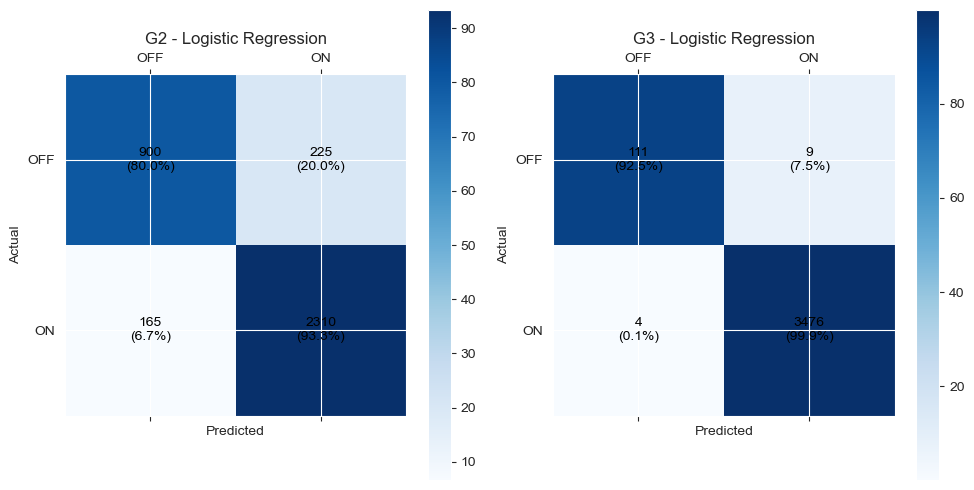

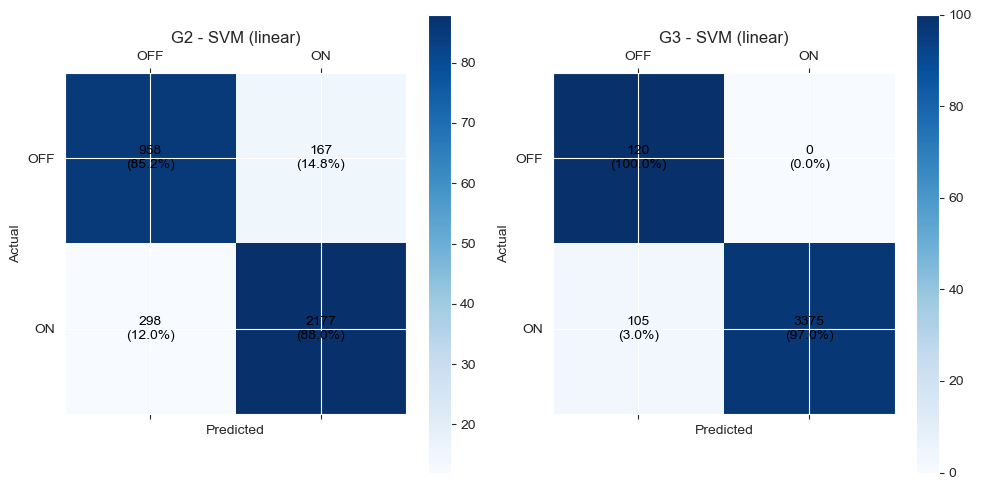

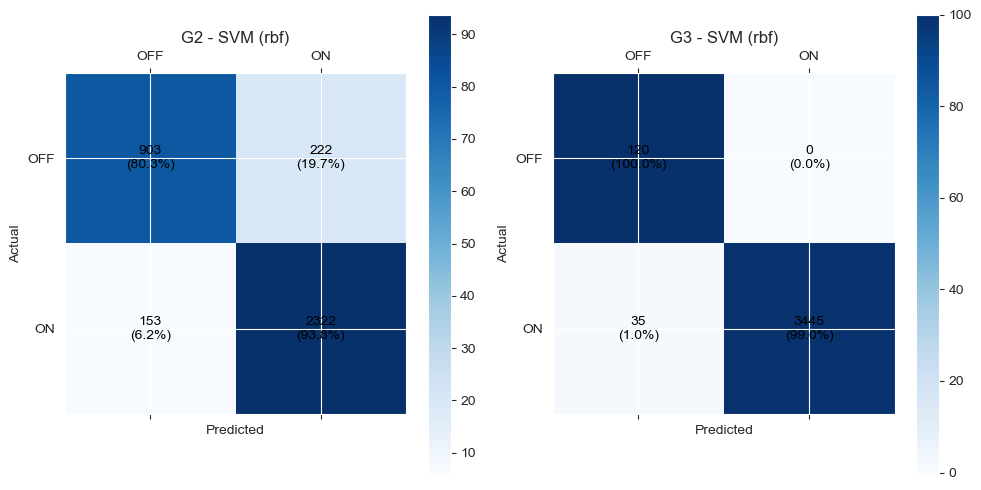

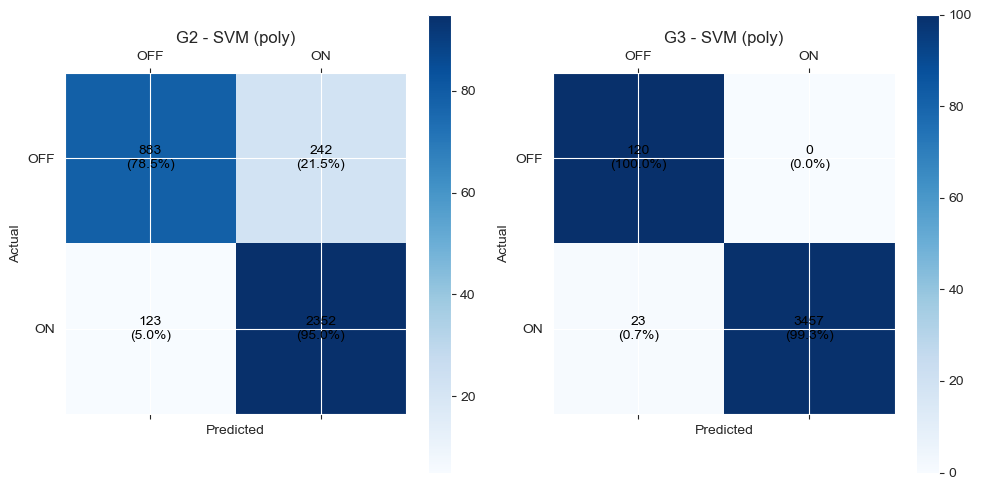

In [64]:
# Plot Confusion Matrices
plot_confusion_matrices(logistic_models, units_to_classify, "Logistic Regression", X_test, y_test)
plot_confusion_matrices(svm_models, units_to_classify, "SVM", X_test, y_test, kernels=kernels)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix without Seaborn
def plot_confusion_matrix_without_seaborn(y_true, y_pred, classes, title="Confusion Matrix"):
    """
    Plots a confusion matrix using matplotlib.

    Args:
    - y_true: List of true labels.
    - y_pred: List of predicted labels.
    - classes: List of class labels.
    - title: Title of the plot.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Display the confusion matrix as a heatmap
    cax = ax.matshow(cm, cmap="Blues")
    fig.colorbar(cax)

    # Annotate the cells with values
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(
                j, i, f"{cm[i, j]}",
                ha="center", va="center", color="black"
            )

    # Set labels, ticks, and title
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title(title)

    # Show the plot
    plt.show()

# Example usage
classes = ['A', 'B', 'C', 'D']
plot_confusion_matrix_without_seaborn(y_val_multi, y_val_pred, classes, title="Logistic Regression (Validation Set)")
plot_confusion_matrix_without_seaborn(y_val_multi, y_val_pred_svm, classes, title="SVM (Validation Set)")


# Step 05: Selection of Final Model

Selection for each individual unit based on MCC:

In [65]:
# Prepare data for G2
smote = SMOTE(random_state=42)
X_train_smote_lagged_G2, y_train_smote_lagged_G2 = smote.fit_resample(X_train_L, y_train_L['G2'])

# Prepare data for G3
X_train_smote_G3, y_train_smote_G3 = smote.fit_resample(X_train, y_train['G3'])

# Train SVM (linear) for G2 with SMOTE + Lagged
svm_linear_G2 = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_linear_G2.fit(X_train_smote_lagged_G2, y_train_smote_lagged_G2)

# Train SVM (poly) for G3 with SMOTE
svm_poly_G3 = SVC(kernel='poly', class_weight='balanced', random_state=42)
svm_poly_G3.fit(X_train_smote_G3, y_train_smote_G3)

# Evaluate models
mcc_g2 = matthews_corrcoef(y_test_L['G2'], svm_linear_G2.predict(X_test_L))
mcc_g3 = matthews_corrcoef(y_test['G3'], svm_poly_G3.predict(X_test))
print(f"MCC G2: {mcc_g2:.3f}, MCC G3: {mcc_g3:.3f}")

# Shape
print("Shapes:", X_train_smote_lagged_G2.shape, y_train_smote_lagged_G2.shape, X_train_smote_G3.shape, y_train_smote_G3.shape)


MCC G2: 0.914, MCC G3: 0.934
Shapes: (23328, 27) (23328,) (32458, 5) (32458,)


--> Not useable for second optimization model due to different shape (SMOTE) 

Consequently, we use Logistic Regression with X_train_L, X_test_L (lagged features):

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

# Shapes
print("Shapes with lagged features: ", X_train_L.shape, X_test_L.shape, y_train_L.shape, y_test_L.shape, X_val_L.shape, y_val_L.shape)

# Logistic Regression Classifier
logistic_models = {}
y_pred = {} 

for unit in units_to_classify:
    model = LogisticRegression(random_state=42, max_iter=1000)
    # Train using lagged features
    model.fit(X_train_L, y_train_L[unit])
    logistic_models[unit] = model

# Evaluate on the validation set
for unit in units_to_classify:
    y_pred[unit] = logistic_models[unit].predict(X_val_L)
    mcc = matthews_corrcoef(y_val_L[unit], y_pred[unit])
    print(f"MCC for {unit} with Logistic Regression and Lagged Features: {mcc:.3f}")

Shapes with lagged features:  (16797, 27) (3600, 27) (16797, 2) (3600, 2) (3600, 27) (3600, 2)
MCC for G2 with Logistic Regression and Lagged Features: 0.897
MCC for G3 with Logistic Regression and Lagged Features: 0.930


In [67]:
# Define the parameter grid for C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize a Logistic Regression model with 'l1' penalty and 'liblinear' solver
base_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)

# Define the GridSearchCV object with MCC as the scoring metric
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=make_scorer(matthews_corrcoef),  # Use MCC for evaluation
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available CPUs
)

# Perform GridSearch for each unit
logistic_models = {}
best_params = {}
y_pred = {} 

for unit in units_to_classify:
    print(f"Performing CV-GridSearch for {unit}...")
    
    # Fit the GridSearch on the training data for the specific unit
    grid_search.fit(X_train_L, y_train_L[unit])
    
    # Save the best model and parameters
    logistic_models[unit] = grid_search.best_estimator_
    best_params[unit] = grid_search.best_params_
    
    print(f"Best C for {unit}: {grid_search.best_params_['C']}")

# Evaluate on the validation set
for unit in units_to_classify:
    y_pred[unit] = logistic_models[unit].predict(X_val_L)
    mcc = matthews_corrcoef(y_val_L[unit], y_pred[unit])
    print(f"MCC for {unit} with Logistic Regression (Best C): {mcc:.3f}")

# Convert results to df
y_pred_df = pd.DataFrame(y_pred)
y_val_df = y_val_L.copy()
X_val_df = X_val_L.copy()
# Remove

# Add a column for G1 with 1 (always ON)
y_pred_df['G1'] = 1
y_val_df['G1'] = 1
# Sort them in G1, G2, G3 order
y_pred_df = y_pred_df[['G1', 'G2', 'G3']]
y_val_df = y_val_df[['G1', 'G2', 'G3']]
print("-"*50)
print(y_pred_df.mean())
print(y_val_df.mean())

# Save the results to a CSV file
y_pred_df.to_csv('Data/y_pred2.csv', index=False)
y_val_df.to_csv('Data/y_val2.csv', index=False)


Performing CV-GridSearch for G2...
Best C for G2: 1
Performing CV-GridSearch for G3...
Best C for G3: 10
MCC for G2 with Logistic Regression (Best C): 0.898
MCC for G3 with Logistic Regression (Best C): 0.949
--------------------------------------------------
G1    1.000000
G2    0.687500
G3    0.965556
dtype: float64
G1    1.000000
G2    0.687500
G3    0.966667
dtype: float64


OSError: Cannot save file into a non-existent directory: 'Data'

Additional threshold GridSearch:

In [ ]:
# Define the parameter grid for C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize a Logistic Regression model with 'l1' penalty and 'liblinear' solver
base_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)

# Define the GridSearchCV object with MCC as the scoring metric
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=make_scorer(matthews_corrcoef),  # Use MCC for evaluation
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available CPUs
)

# Perform GridSearch for each unit
logistic_models = {}
best_params = {}
y_pred_proba = {}  # Store predicted probabilities

for unit in units_to_classify:
    print(f"Performing CV-GridSearch for {unit}...")
    
    # Fit the GridSearch on the training data for the specific unit
    grid_search.fit(X_train_L, y_train_L[unit])
    
    # Save the best model and parameters
    logistic_models[unit] = grid_search.best_estimator_
    best_params[unit] = grid_search.best_params_
    
    print(f"Best C for {unit}: {grid_search.best_params_['C']}")

# Evaluate on the validation set across thresholds
thresholds = np.arange(0.1, 1.0, 0.1)  # Define thresholds from 0.1 to 0.9
mcc_results = {unit: [] for unit in units_to_classify}

for unit in units_to_classify:
    y_pred_proba[unit] = logistic_models[unit].predict_proba(X_val_L)[:, 1]  # Probabilities for class 1
    for threshold in thresholds:
        # Apply the threshold to generate binary predictions
        y_pred_binary = (y_pred_proba[unit] >= threshold).astype(int)
        # Calculate MCC for the unit at this threshold
        mcc = matthews_corrcoef(y_val_L[unit], y_pred_binary)
        mcc_results[unit].append((threshold, mcc))

# Convert MCC results to df for analysis
mcc_results_df = {unit: pd.DataFrame(mcc_results[unit], columns=['Threshold', 'MCC']) for unit in units_to_classify}

# Find the best threshold for each unit
best_thresholds = {}
for unit in units_to_classify:
    best_row = mcc_results_df[unit].iloc[mcc_results_df[unit]['MCC'].idxmax()]
    best_thresholds[unit] = (best_row['Threshold'], best_row['MCC'])
    print(f"Best threshold for {unit}: {best_thresholds[unit][0]:.2f} with MCC: {best_thresholds[unit][1]:.3f}")

# Final predictions using the best thresholds
y_pred_final = {}
for unit in units_to_classify:
    y_pred_final[unit] = (y_pred_proba[unit] >= best_thresholds[unit][0]).astype(int)

# Convert results to DataFrame
y_pred_df = pd.DataFrame(y_pred_final)
y_val_df = y_val_L.copy()
X_val_df = X_val_L.copy()
# Add a column for G1 with 1 (always ON)
y_pred_df['G1'] = 1
y_val_df['G1'] = 1
# Drop the lagged features
X_val_df = X_val_df.drop(columns=[col for col in X_val_df.columns if 'lag' in col])
# X_val_df = scaler.inverse_transform(X_val_df)

# Sort columns in G1, G2, G3 order
y_pred_df = y_pred_df[['G1', 'G2', 'G3']]
y_val_df = y_val_df[['G1', 'G2', 'G3']]
# Rename the columns of X_val_df
X_val_df.columns = ['W1', 'W2', 'L1', 'L2', 'L3', 'Hour']
# Sort columns in sample order
X_val_df = X_val_df[['Hour', 'W1', 'W2', 'L1', 'L2', 'L3']]
cols_to_scale = ['W1', 'W2', 'L1', 'L2', 'L3']
# Revert the scaling
X_val_df[cols_to_scale] = scaler.inverse_transform(X_val_df[cols_to_scale])

print("-" * 50)
print("Mean Predictions:")
print(y_pred_df.mean())
print("Mean True Values:")
print(y_val_df.mean())

# Save the results to a CSV file
y_pred_df.to_csv('Data/y_pred.csv', index=False)
y_val_df.to_csv('Data/y_val.csv', index=False)
X_val_df.to_csv('Data/X_val.csv', index=False)

In [ ]:
print(X_val_df.mean())
X_val_df.head(10)